## Chapter 12: Causal Inference in Economic Research 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from causallib.estimation import IPW
from causallib.evaluation import evaluate
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Loading the datasets

In [5]:
columns = ["treat", "age", "education", "black", "hispanic",
           "married", "nodegree", "re74", "re75", "re78"]

urls = ["http://www.nber.org/~rdehejia/data/nswre74_treated.txt",
        "http://www.nber.org/~rdehejia/data/cps3_controls.txt"]
data = [pd.read_csv(url, sep='\s+', header=None, names=columns) for url in urls]
lalonde = pd.concat(data, ignore_index=True)
lalonde

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899
...,...,...,...,...,...,...,...,...,...,...
609,0.0,18.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,10150.5000
610,0.0,24.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,19464.6100
611,0.0,21.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
612,0.0,32.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,187.6713


### EDA

In [6]:
lalonde.describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [7]:
lalonde.groupby('treat')['re78'].mean().round(2)

treat
0.0    6984.17
1.0    6349.14
Name: re78, dtype: float64

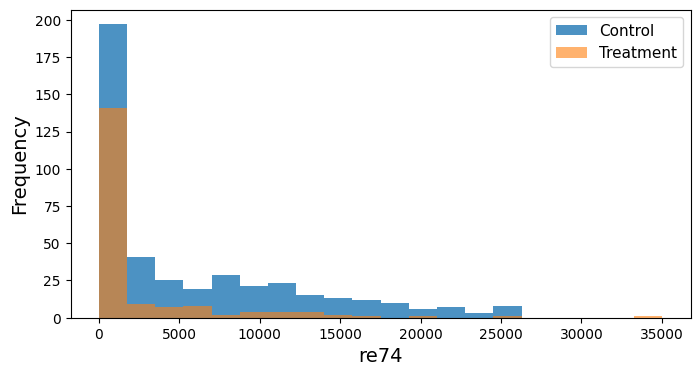

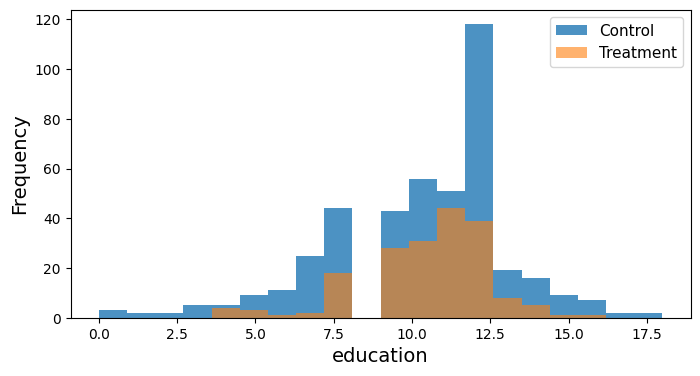

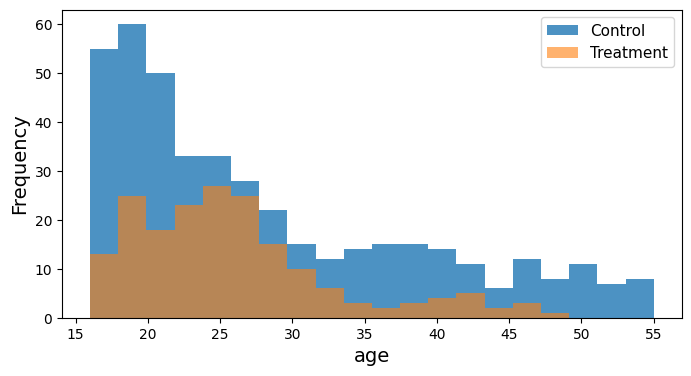

In [8]:
treated = lalonde[lalonde['treat'] == 1]
control = lalonde[lalonde['treat'] == 0]
for col in ['re74', 'education', 'age']:
    plt.figure(figsize=(8, 4))
    min_val, max_val = np.min(lalonde[col]), np.max(lalonde[col]) 
    bins = np.linspace(min_val, max_val, 21)
    plt.hist(control[col], bins=bins, alpha=0.8, label='Control')
    plt.hist(treated[col], bins=bins, alpha=0.6, label='Treatment')
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(fontsize=11)
    plt.show()

In [9]:
lalonde.groupby('treat')[['black', 'hispanic', 'married', 'nodegree']].mean().round(2)

,black,hispanic,married,nodegree
treat,,,,
0.0,0.20,0.14,0.51,0.60
1.0,0.84,0.06,0.19,0.71


### Estimation using Standardization

In [10]:
covariates = ['age', 'education', 'black', 'hispanic',
              'married', 'nodegree', 're74', 're75']
X = lalonde[covariates]
X1 = sm.add_constant(X)  
T = lalonde['treat']
Y = lalonde['re78']

model = sm.OLS(Y, pd.concat([X1, T], axis=1))
results = model.fit(cov_type='HC0')
cols = {"Estimation": [results.params['treat']],
        "Standard error": [results.bse['treat']],
        "p-value": [results.pvalues['treat']],
         "95% conf interval": [results.conf_int().loc["treat"].round(3).tolist()]}
output = pd.DataFrame(cols, index=["ATE"])
output.round(3)

,Estimation,Standard error,p-value,95% conf interval
ATE,1548.244,734.521,0.035,"[108.61, 2987.878]"


### Estimation using Inverse Probability Weighting

In [11]:
learner = LogisticRegression(penalty=None, solver='lbfgs',
                             max_iter=500)    

In [12]:
ipw = IPW(learner)
ipw.fit(X, T)

IPW(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.6/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=500, penalty=None))

In [13]:
propensity_scores = ipw.compute_propensity(X, T, treatment_values=1)
lalonde['propensity_score'] = propensity_scores  
lalonde

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,propensity_score
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460,0.643200
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940,0.223668
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500,0.677393
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460,0.775655
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899,0.700268
...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,18.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,10150.5000,0.122395
610,0.0,24.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,19464.6100,0.035161
611,0.0,21.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.182550
612,0.0,32.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,187.6713,0.387573


In [14]:
outcome_1 = ((T*Y / propensity_scores) / (T / propensity_scores).sum()).sum()
outcome_0 = ((1-T)*Y / (1-propensity_scores) / ((1-T) / (1-propensity_scores)).sum()).sum()
effect = outcome_1 - outcome_0

In [15]:
print("Outcomes:\n 0: {} \n 1: {}".format(outcome_0, outcome_1))
print("Effect: ", effect)

Outcomes:
 0: 6423.097413492358 
 1: 6653.0304883449135
Effect:  229.93307485255536


In [16]:
outcomes = ipw.estimate_population_outcome(X, T, Y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])

In [17]:
print("Outcomes:")
print(outcomes)
print("Effect: ", effect)

Outcomes:
0.0    6423.097413
1.0    6653.030488
dtype: float64
Effect:  diff    229.933075
dtype: float64


In [18]:
np.random.seed(10)
n_iterations = 500
ate_samples = []
learner1 = LogisticRegression(penalty=None, solver='lbfgs',
                             max_iter=500)  
for _ in range(n_iterations):
    # Create a bootstrap sample
    X_resampled, T_resampled, Y_resampled = resample(X, T, Y)
    
    # Fit IPW model and estimate ATE
    ipw_s = IPW(learner1)
    ipw_s.fit(X_resampled, T_resampled)
    outcomes = ipw.estimate_population_outcome(X_resampled, T_resampled, Y_resampled)
    ate_resampled = ipw.estimate_effect(outcomes[1], outcomes[0])
    ate_samples.append(ate_resampled)

# Calculate the confidence intervals
ate_samples = np.array(ate_samples)
lower_bound = np.percentile(ate_samples, 2.5)
upper_bound = np.percentile(ate_samples, 97.5)
# Calculate the standard error as the standard deviation of bootstrap ATE estimates
standard_error = np.std(ate_samples, ddof=1)

print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")
print(f"Standard Error: {standard_error}")

95% Confidence Interval: [-1443.4236683170232, 1915.799372820243]
Standard Error: 866.049117007221


### Balance plots

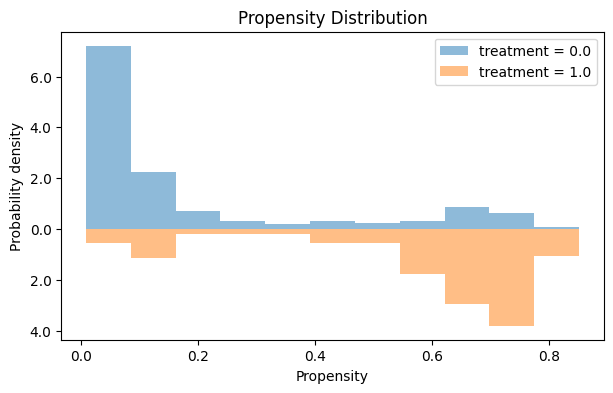

In [19]:
plt.figure(figsize=(7, 4))
evaluation_results = evaluate(ipw, X, T, Y)
evaluation_results.plot_weight_distribution()
plt.show()

In [20]:
covariate = 'age'
mean_xi_t = treated[covariate].mean()
mean_xi_c = control[covariate].mean()
std_xi_t = treated[covariate].std(ddof=0)
std_xi_c = control[covariate].std(ddof=0)
smd = (mean_xi_t - mean_xi_c) / np.sqrt(std_xi_t**2 + std_xi_c**2)
print("SMD for age:", np.round(smd, 4))

SMD for age: -0.1713


In [21]:
treated = lalonde[lalonde['treat'] == 1]
control = lalonde[lalonde['treat'] == 0]
w_t = 1/treated['propensity_score']
w_c = 1/(1-control['propensity_score'])

numerator = np.average(treated[covariate], weights=w_t) - np.average(control[covariate], weights=w_c) 
denominator = np.sqrt(np.var(treated[covariate]) + np.var(control[covariate])) 
weightes_smd = numerator / denominator
print("Weighted SMD for age:", np.round(weightes_smd, 4))

Weighted SMD for age: -0.1189


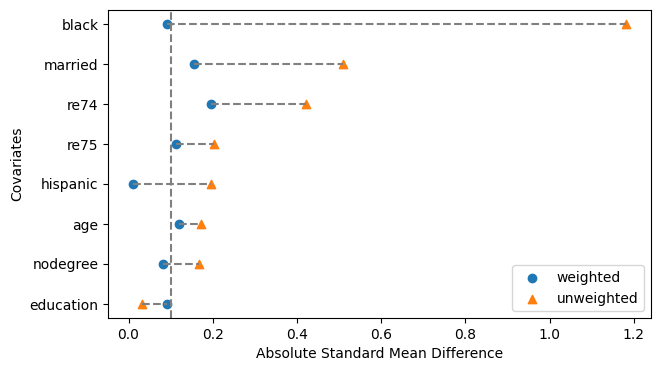

In [22]:
plt.figure(figsize=(7, 4))
evaluation_results.plot_covariate_balance(kind="love", thresh=0.1)
plt.show()

### Estimation using Propensity Score Matching

In [23]:
lalonde_trimmed = lalonde[lalonde['propensity_score'] <= 0.8]
treated_trimmed = lalonde_trimmed[lalonde_trimmed['treat'] == 1]
control_trimmed = lalonde_trimmed[lalonde_trimmed['treat'] == 0]
print("Shape of trimmed dataset", lalonde_trimmed.shape)
print("Shape of treatment group", treated_trimmed.shape)

Shape of trimmed dataset (609, 11)
Shape of treatment group (180, 11)


In [24]:
knn = NearestNeighbors(n_neighbors=1)
knn.fit(control_trimmed[['propensity_score']])
_, indices = knn.kneighbors(treated_trimmed[['propensity_score']])
control_matched = control.iloc[indices.flatten()]
lalonde_matched = pd.concat([treated_trimmed, control_matched])
print("Shape of the matched dataset:", lalonde_matched.shape)

Shape of the matched dataset: (360, 11)


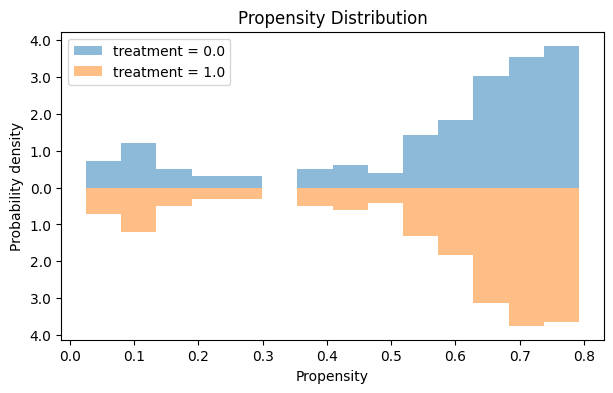

In [25]:
X_matched = lalonde_matched[covariates]
Y_matched = lalonde_matched['re78']
T_matched = lalonde_matched['treat']

plt.figure(figsize=(7, 4))
evaluation_results = evaluate(ipw, X_matched, T_matched, Y_matched)
evaluation_results.plot_weight_distribution()
plt.show()

In [26]:
evaluation_results = evaluate(ipw, X_matched, T_matched, Y_matched)
evaluation_results.evaluated_metrics.covariate_balance['unweighted']

covariate
age          0.140419
education    0.022224
black        0.021084
hispanic     0.016064
married      0.117134
nodegree     0.000000
re74         0.058005
re75         0.096181
Name: unweighted, dtype: float64

In [27]:
treated_matched = lalonde_matched[lalonde_matched['treat']==1]
control_matched= lalonde_matched[lalonde_matched['treat']==0]

In [28]:
EY_1 = treated_matched['re78'].mean()
EY_0 =  control_matched['re78'].mean()
effect = EY_1 - EY_0

print("Outcomes:\n 0: {} \n 1: {}".format(EY_0, EY_1))
print("Effect: ", effect)

Outcomes:
 0: 5318.124665666667 
 1: 6362.802889444443
Effect:  1044.678223777776
